In [1]:
#| default_exp preprocessing.lesson17

# Lesson17
> Reproducing lesson 17

In [44]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
#| export
from cv_tools.core import *
from fastcore.all import *


In [46]:
#| export
import sys, traceback, gc


In [165]:
#| export
import torch
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
from torcheval.metrics import MulticlassAccuracy
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)


In [48]:
#| export
import logging
logging.disable(logging.WARNING)

In [49]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [50]:
#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [51]:
#| export
def clean_mem(torch_:bool=True):
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    if torch_: torch.cuda.empty_cache()

In [52]:
clean_mem()

# Get data

In [70]:
#| exporti
from fastai_course22p2.preprocessing.lesson16_after_lesson import *
from fastai_course22p2.preprocessing.lesson16_second_part import *

In [54]:
set_seed(42)

In [55]:
#| export
@inplace
def transformi(b): b['image'] = TF.to_tensor(b['image'])


In [56]:
dls = prep_data()

In [57]:
x, y = next(iter(dls.train))
x.shape, y[:10]


(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [58]:
#| export
def_device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = def_device

In [59]:
#| export
def get_model():
	return nn.Sequential(
		conv(1, 8), 
		conv(8, 16), 
		conv(16, 32), 
		conv(32, 64), 
		conv(64,10, act=False), 
		nn.Flatten()).to(device)


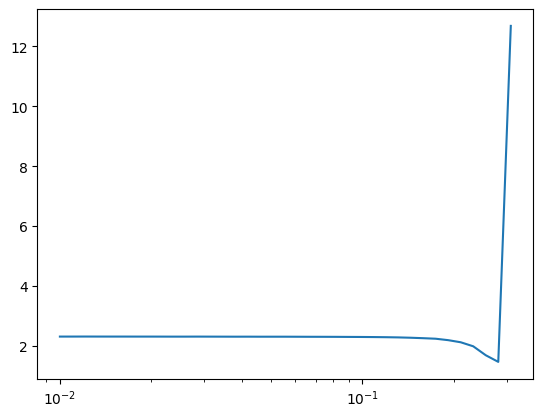

In [61]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
MomentumLearner(
	get_model(), 
    dls, 
    loss_func=F.cross_entropy, 
    cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [71]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(
	get_model(), 
	dls,
    loss_func=F.cross_entropy,lr=0.2, cbs=cbs)

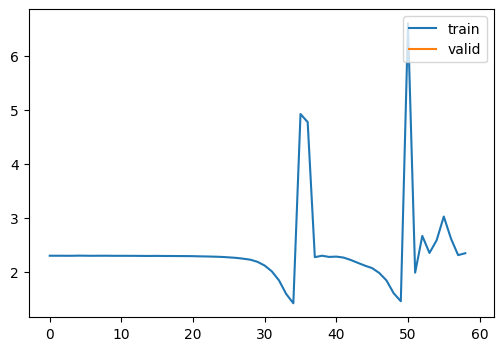

In [72]:
learn.fit(1)

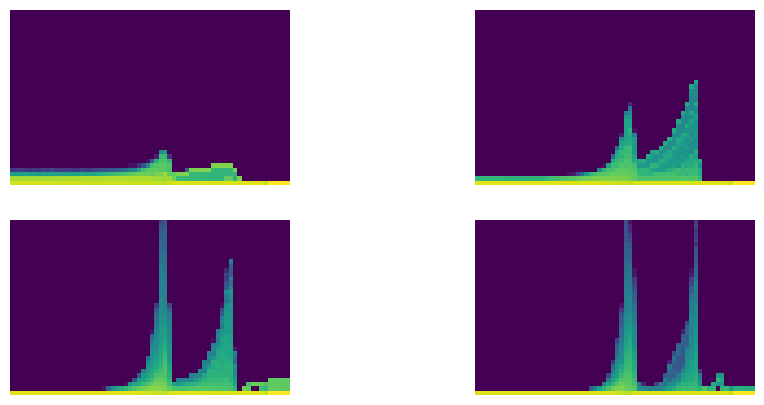

In [73]:
astats.color_dim()

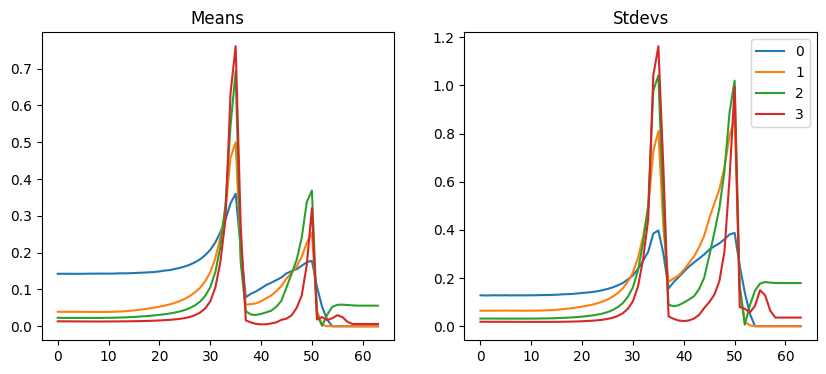

In [74]:
astats.plot_stats()

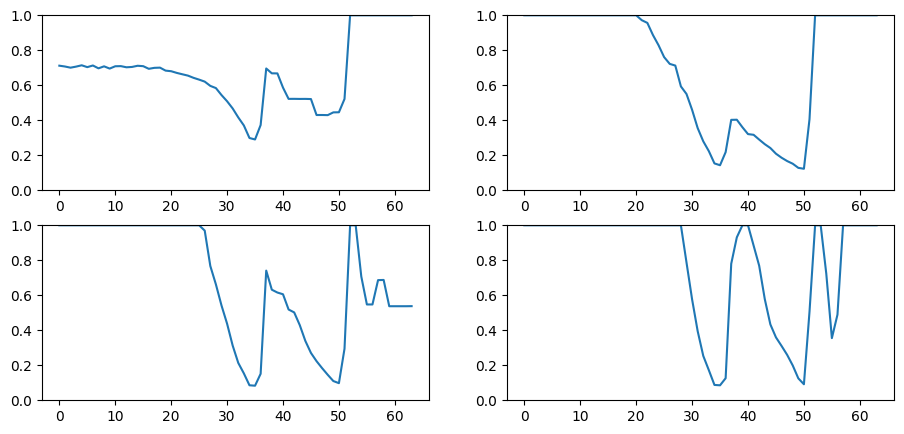

In [75]:
astats.dead_chart()

# Initialization

### Kaiming He Initialization

In [81]:
#| export
from math import sqrt

In [77]:
x = torch.randn(200,100)
y = torch.randn(200)

In [85]:
w1 = torch.randn(100,50)/sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1)/sqrt(50)
b2 = torch.zeros(1)

In [83]:
def lin(x, w, b): return x@w + b

In [86]:
l1 = lin(x, w1, b1)
l1.mean(), l1.std()

(tensor(0.00), tensor(1.00))

In [87]:
def relu(x): return x.clamp_min(0)
l2 = relu(lin(x, w1, b1))
l2.mean(), l2.std()


(tensor(0.40), tensor(0.59))

In [95]:
x = torch.randn(200,100)
w1 = torch.randn(100,50)*sqrt(2/100)
l1 = lin(x, w1, b1)
l1.mean(), l1.std()


(tensor(-0.03), tensor(1.41))

> `RelU` is changing mean 0 and std 1

In [105]:
x = torch.randn(200,100)
w1 = torch.randn(100,50)*sqrt(2/100)
l1 = relu(lin(x, w1, b1))
l1.mean(), l1.std()


(tensor(0.56), tensor(0.84))

### Apply an init function

In [106]:
model = get_model()
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [114]:
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [117]:
#| export
def init_weights(m):
	if isinstance(m, (nn.Conv2d, nn.Conv1d, nn.Conv3d)):
		nn.init.kaiming_normal_(m.weight)
		


In [119]:
model.apply(init_weights);


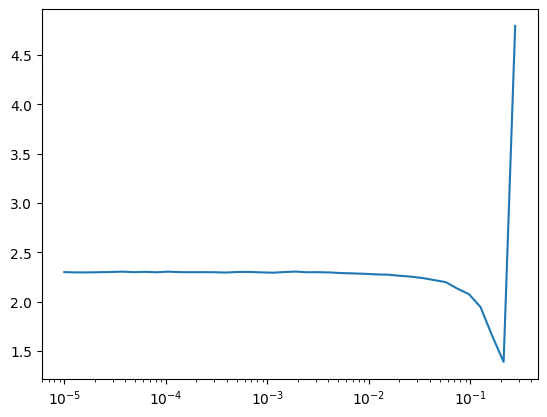

In [120]:
MomentumLearner(
    model, dls, loss_func=F.cross_entropy, cbs=[DeviceCB()]).lr_find()

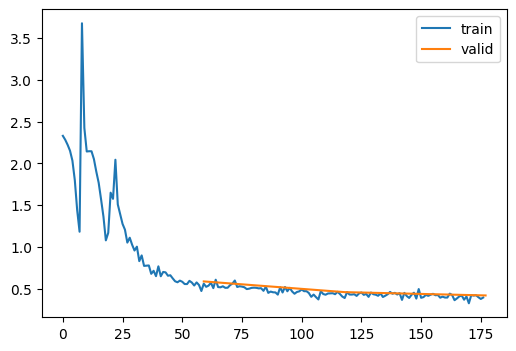

In [127]:
set_seed(42)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(
    get_model().apply(init_weights), 
    dls, 
    loss_func=F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)



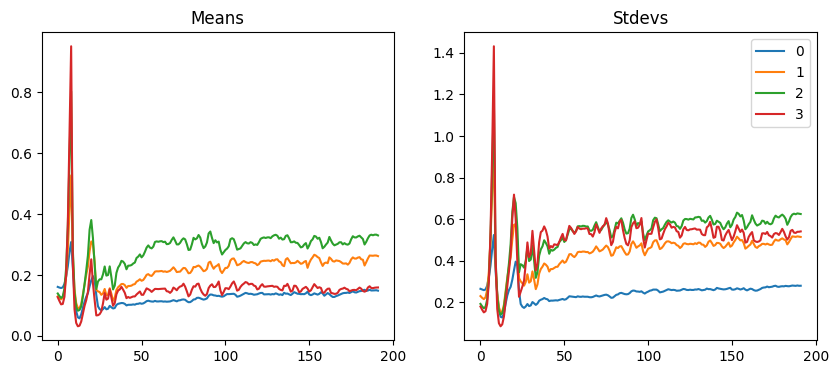

In [128]:
astats.plot_stats()

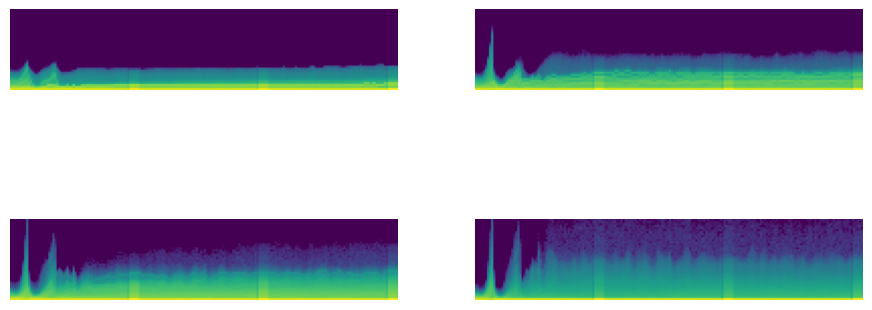

In [129]:
astats.color_dim()

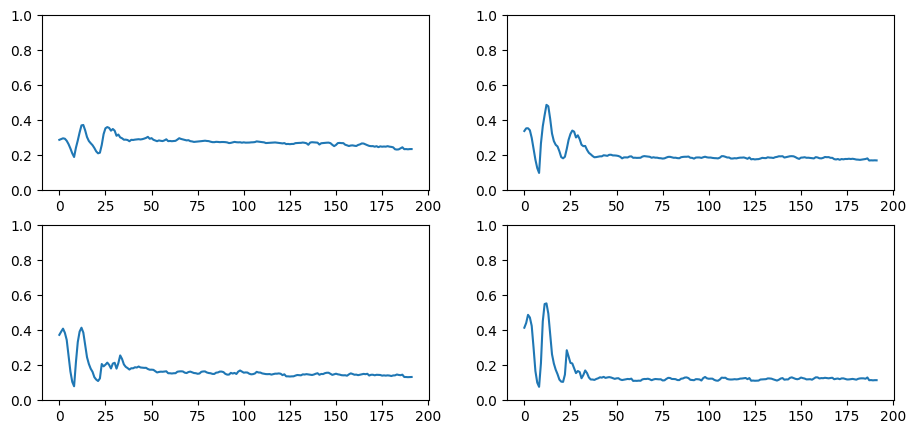

In [130]:
astats.dead_chart()

# Input normalization


In [145]:
xb, yb = next(iter(dls.train))
xb.shape, yb.shape
xmean, xstd = xb.mean(), xb.std()
xmean, xstd

(tensor(0.29), tensor(0.35))

In [153]:
#| export
class BatchTransformCB(Callback):
	def __init__(
			self, tfm,
			on_train=True, on_val=True):
		store_attr()

	def before_batch(self, learn):
		if (self.on_train and learn.training) or (self.on_val and not learn.training):
			learn.batch = self.tfm(learn.batch)

In [154]:
#| export
def _norm(batch):
	return (batch[0] - xmean ) / xstd, batch[1]

norm = BatchTransformCB(_norm)

accuracy,loss,epoch,train
0.526,1.472,0,train
0.748,0.650,0,eval
0.809,0.518,1,train
0.815,0.504,1,eval
0.843,0.430,2,train
0.841,0.435,2,eval


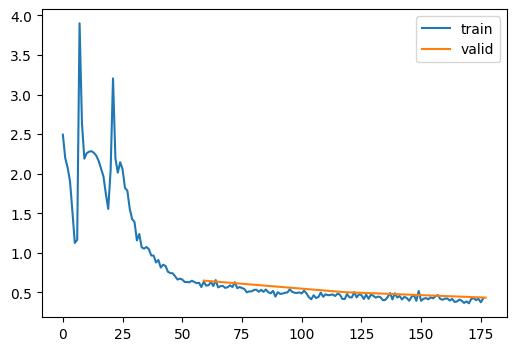

In [156]:
set_seed(42)
#metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs= [
    DeviceCB(), 
    metrics, 
    ProgressCB(plot=True), 
    astats]
learn = MomentumLearner(
    get_model().apply(init_weights), 
    dls, 
    loss_func=F.cross_entropy, 
	lr=0.2,
    cbs=cbs+[norm])
learn.fit(3)


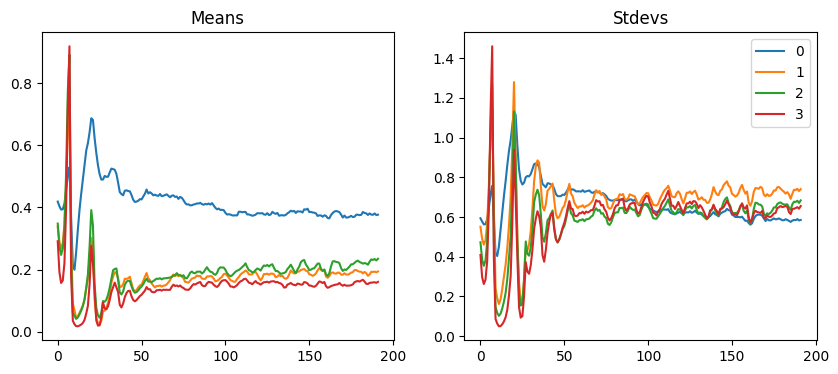

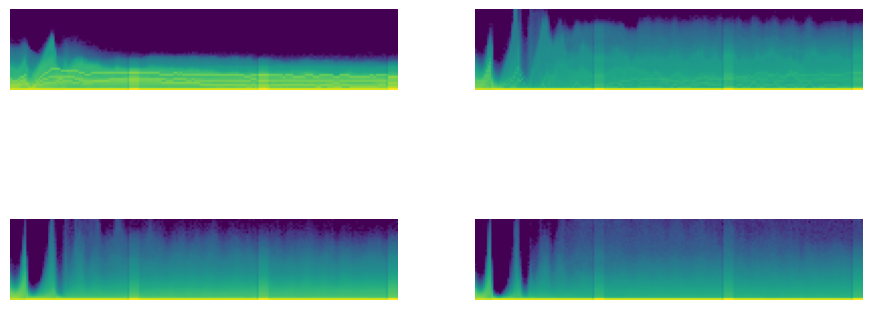

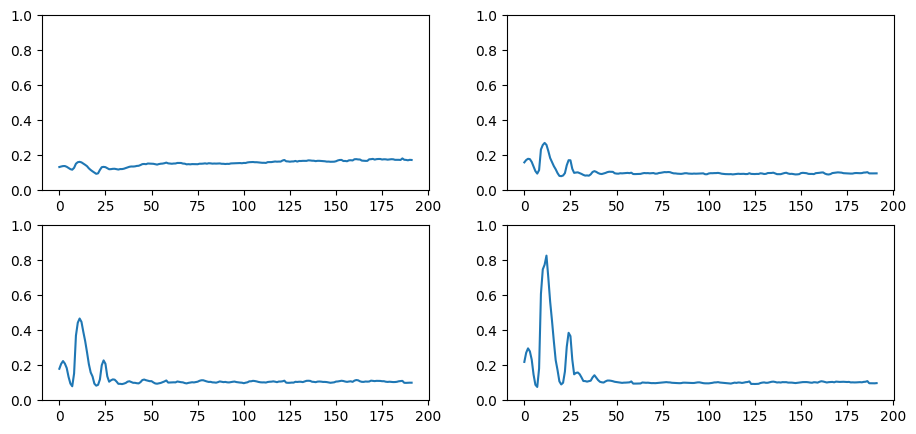

In [157]:
astats.plot_stats()
astats.color_dim()
astats.dead_chart()


> Apply this normalization to whole dataset

In [162]:
prep_data?

Signature: prep_data()
Docstring: <no docstring>
File:      ~/Schreibtisch/projects/git_data/fastai_course22p2/fastai_course22p2/preprocessing/lesson16_second_part.py
Type:      function

In [180]:
@inplace
def transformi(b): b['image'] = [(TF.to_tensor(o) -xmean)/xstd for o in b['image']]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=1024, num_workers=0)
xb, yb = next(iter(dls.train))
xb.mean(), xb.std()



(tensor(0.00), tensor(1.00))

## General RelU

In [0]:
#| hide
import nbdev; nbdev.nbdev_export('05_preprocessing.lesson_17.ipynb')